# **Setup and Mount Drive**

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Install required libraries
!pip install librosa

# Import all necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import librosa
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import IPython.display as ipd

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

Mounted at /content/drive


# **Data Loading Functions and Load Data**

In [ ]:
# Data loading and preprocessing functions
def load_esc50_data(data_path, num_samples=500, audio_length=22050):
    """Load ESC-50 audio files"""
    audio_files = []
    audio_dir = os.path.join(data_path, 'audio')

    # Verify audio directory exists
    if not os.path.exists(audio_dir):
        raise FileNotFoundError(f"Audio directory not found at {audio_dir}")

    # Get list of all wav files
    all_files = [f for f in os.listdir(audio_dir) if f.endswith('.wav')]

    # Use minimum of requested samples and available files
    num_to_load = min(num_samples, len(all_files))
    files_to_load = all_files[:num_to_load]

    print(f"Loading {num_to_load} audio files from {len(all_files)} available...")

    for i, file in enumerate(files_to_load):
        if i % 20 == 0:
            print(f"Loaded {i}/{num_to_load} files...")

        file_path = os.path.join(audio_dir, file)
        try:
            audio, _ = librosa.load(file_path, sr=22050, duration=1.0)
            # Pad or trim to fixed length
            if len(audio) < audio_length:
                audio = np.pad(audio, (0, audio_length - len(audio)), mode='constant')
            else:
                audio = audio[:audio_length]

            audio_files.append(audio)
        except Exception as e:
            print(f"Error loading {file}: {e}")

    print(f"Successfully loaded {len(audio_files)} files")
    return np.array(audio_files)

def generate_random_messages(num_messages, message_length=128):
    """Generate random binary messages"""
    return np.random.randint(0, 2, size=(num_messages, message_length)).astype(np.float32)

def prepare_training_data(audio_data, message_data):
    """Prepare data for training"""
    # Reshape audio for Conv1D
    audio_data = audio_data.reshape(-1, audio_data.shape[1], 1)

    # Normalize audio to [-1, 1]
    max_val = np.max(np.abs(audio_data))
    if max_val > 0:
        audio_data = audio_data / max_val

    return audio_data, message_data

# Load the data
print("\nLoading ESC-50 data...")
data_path="/content/drive/MyDrive/graduation project/ESC-50-master"
try:
    # Load audio data (start with 200 samples)
    audio_data = load_esc50_data(data_path, num_samples=800)
    print(f"✓ Loaded {len(audio_data)} audio samples")

    # Generate random messages
    message_data = generate_random_messages(len(audio_data), message_length=128)
    print(f"✓ Generated {len(message_data)} random messages")

    # Prepare data
    audio_data, message_data = prepare_training_data(audio_data, message_data)
    print(f"\nData shapes:")
    print(f"  Audio data: {audio_data.shape}")
    print(f"  Message data: {message_data.shape}")
    print(f"  Audio range: [{np.min(audio_data):.3f}, {np.max(audio_data):.3f}]")

except Exception as e:
    print(f"✗ Error loading data: {e}")
    print("Please check that the dataset path is correct")


Loading ESC-50 data...
Loading 800 audio files from 2000 available...
Loaded 0/800 files...
Loaded 20/800 files...
Loaded 40/800 files...
Loaded 60/800 files...
Loaded 80/800 files...
Loaded 100/800 files...
Loaded 120/800 files...
Loaded 140/800 files...
Loaded 160/800 files...
Loaded 180/800 files...
Loaded 200/800 files...
Loaded 220/800 files...
Loaded 240/800 files...
Loaded 260/800 files...
Loaded 280/800 files...
Loaded 300/800 files...
Loaded 320/800 files...
Loaded 340/800 files...
Loaded 360/800 files...
Loaded 380/800 files...
Loaded 400/800 files...
Loaded 420/800 files...
Loaded 440/800 files...
Loaded 460/800 files...
Loaded 480/800 files...
Loaded 500/800 files...
Loaded 520/800 files...
Loaded 540/800 files...
Loaded 560/800 files...
Loaded 580/800 files...
Loaded 600/800 files...
Loaded 620/800 files...
Loaded 640/800 files...
Loaded 660/800 files...
Loaded 680/800 files...
Loaded 700/800 files...
Loaded 720/800 files...
Loaded 740/800 files...
Loaded 760/800 files...

# **Quick Data Visualization**

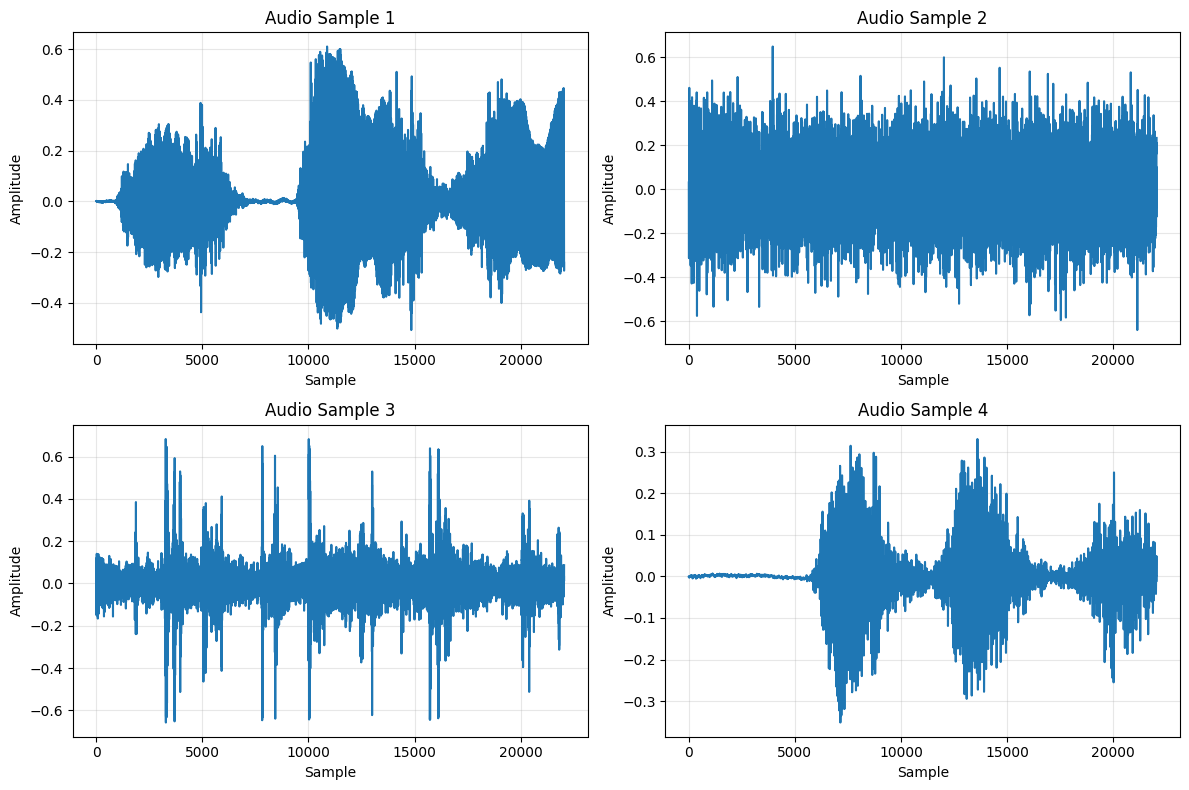

Sample message (first 32 bits):
[0 0 1 0 0 1 0 1 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 0 0 0 1 0]

Playing sample audio (first file):


In [ ]:
# Visualize some loaded audio samples
if 'audio_data' in globals() and len(audio_data) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()

    for i in range(min(4, len(audio_data))):
        axes[i].plot(audio_data[i].flatten())
        axes[i].set_title(f'Audio Sample {i+1}')
        axes[i].set_xlabel('Sample')
        axes[i].set_ylabel('Amplitude')
        axes[i].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Show message sample
    print("Sample message (first 32 bits):")
    print(message_data[0][:32].astype(int))

    # Play a sample audio
    print("\nPlaying sample audio (first file):")
    ipd.display(ipd.Audio(audio_data[0].flatten(), rate=22050))
else:
    print("No audio data loaded yet!")

# **Model Definition**

In [ ]:
class AudioSteganographyModel:
    def __init__(self, audio_length=22050, message_length=128):
        self.audio_length = audio_length
        self.message_length = message_length
        self.sr = 22050

        # Build the models
        self.encoder = self._build_encoder()
        self.decoder = self._build_decoder()
        self.combined_model = self._build_combined_model()

    def _build_encoder(self):
        """Improved encoder with stronger embedding"""
        audio_input = layers.Input(shape=(self.audio_length, 1), name='audio_input')
        message_input = layers.Input(shape=(self.message_length,), name='message_input')

        # Process audio with more layers
        x = layers.Conv1D(32, 9, padding='same', activation='relu')(audio_input)
        x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
        x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)

        # Stronger message embedding
        message_dense = layers.Dense(512, activation='relu')(message_input)
        message_dense = layers.Dense(1024, activation='relu')(message_dense)

        # Expand to audio length
        message_expanded = layers.RepeatVector(self.audio_length)(message_dense)
        message_features = layers.Conv1D(32, 1, padding='same', activation='tanh')(message_expanded)

        # INCREASE embedding strength
        embedding_strength = 0.05  # Was 0.01 - try 5x stronger
        message_signal = layers.Lambda(lambda x: x * embedding_strength)(message_features)

        # Combine using concatenation instead of addition
        combined = layers.Concatenate()([x, message_signal])

        # More processing layers
        x = layers.Conv1D(64, 5, padding='same', activation='relu')(combined)
        x = layers.Conv1D(32, 5, padding='same', activation='relu')(x)
        x = layers.Conv1D(16, 3, padding='same', activation='relu')(x)

        # Output with residual connection
        stego_audio = layers.Conv1D(1, 1, padding='same', activation='tanh')(x)
        # Add residual to preserve more of original audio
        stego_audio = layers.Add()([audio_input, stego_audio])

        encoder = models.Model(inputs=[audio_input, message_input], outputs=stego_audio, name='encoder')
        return encoder

    def _build_decoder(self):
        """Improved decoder with temporal awareness"""
        stego_input = layers.Input(shape=(self.audio_length, 1), name='stego_input')

        # Multi-scale feature extraction
        x1 = layers.Conv1D(64, 3, padding='same', activation='relu')(stego_input)
        x1 = layers.MaxPooling1D(2)(x1)

        x2 = layers.Conv1D(64, 9, padding='same', activation='relu')(stego_input)
        x2 = layers.MaxPooling1D(2)(x2)

        x3 = layers.Conv1D(64, 15, padding='same', activation='relu')(stego_input)
        x3 = layers.MaxPooling1D(2)(x3)

        # Combine multi-scale features
        x = layers.Concatenate()([x1, x2, x3])

        x = layers.Conv1D(128, 3, padding='same', activation='relu')(x)
        x = layers.MaxPooling1D(2)(x)
        x = layers.Conv1D(256, 3, padding='same', activation='relu')(x)

        # Use GlobalAveragePooling instead of Max to retain more info
        x = layers.GlobalAveragePooling1D()(x)

        # Deeper dense layers
        x = layers.Dense(1024, activation='relu')(x)
        x = layers.Dropout(0.3)(x)
        x = layers.Dense(512, activation='relu')(x)
        x = layers.Dropout(0.3)(x)
        x = layers.Dense(256, activation='relu')(x)

        extracted_message = layers.Dense(self.message_length, activation='sigmoid')(x)

        decoder = models.Model(inputs=stego_input, outputs=extracted_message, name='decoder')
        return decoder

    def _build_combined_model(self):
        """Combined model for end-to-end training"""
        audio_input = layers.Input(shape=(self.audio_length, 1), name='audio_input')
        message_input = layers.Input(shape=(self.message_length,), name='message_input')

        # Encode
        stego_audio = self.encoder([audio_input, message_input])

        # Decode
        extracted_message = self.decoder(stego_audio)

        model = models.Model(
            inputs=[audio_input, message_input],
            outputs=[stego_audio, extracted_message],
            name='steganography_model'
        )

        return model

    def compile_model(self, learning_rate=0.001):
        """Compile with balanced loss weights"""
        optimizer = optimizers.Adam(learning_rate=learning_rate)

        # Balanced weights
        audio_loss_weight = 10.0
        message_loss_weight =1.0

        self.combined_model.compile(
            optimizer=optimizer,
            loss = {
                'encoder' : 'mae',
                'decoder'  : tf.keras.losses.BinaryCrossentropy(from_logits=False)},
            loss_weights=[audio_loss_weight, message_loss_weight],
            metrics = {
            'decoder': tf.keras.metrics.BinaryAccuracy(name='bit_acc', threshold=0.5)}
        )

# Create model instance
print("Building Audio Steganography Model...")
stego_model = AudioSteganographyModel(audio_length=22050, message_length=128)
stego_model.compile_model(learning_rate=0.001)

print("\n" + "="*50)
print("ENCODER MODEL SUMMARY:")
print("="*50)
stego_model.encoder.summary()

print("\n" + "="*50)
print("DECODER MODEL SUMMARY:")
print("="*50)
stego_model.decoder.summary()

print("\n" + "="*50)
print("COMBINED MODEL SUMMARY:")
print("="*50)
print(f"Total parameters: {stego_model.combined_model.count_params():,}")

Building Audio Steganography Model...

ENCODER MODEL SUMMARY:


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ message_input       │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 512)       │     66,048 │ message_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ audio_input         │ (None, 22050, 1)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1024)      │    525,312 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 22050, 32) │        320 │ audio_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_2     │ (None, 22050,     │          0 │ dense_9[0][0]     │
│ (RepeatVector)      │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 22050, 64) │     18,496 │ conv1d_14[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 22050, 32) │     32,800 │ repeat_vector_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 22050, 64) │     36,928 │ conv1d_15[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 22050, 32) │          0 │ conv1d_17[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 22050, 96) │          0 │ conv1d_16[0][0],  │
│ (Concatenate)       │                   │            │ lambda_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_18 (Conv1D)  │ (None, 22050, 64) │     30,784 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_19 (Conv1D)  │ (None, 22050, 32) │     10,272 │ conv1d_18[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_20 (Conv1D)  │ (None, 22050, 16) │      1,552 │ conv1d_19[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_21 (Conv1D)  │ (None, 22050, 1)  │         17 │ conv1d_20[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 22050, 1)  │          0 │ audio_input[0][0… │
│                     │                   │            │ conv1d_21[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 722,529 (2.76 MB)

 Trainable params: 722,529 (2.76 MB)

 Non-trainable params: 0 (0.00 B)


DECODER MODEL SUMMARY:


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ stego_input         │ (None, 22050, 1)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_22 (Conv1D)  │ (None, 22050, 64) │        256 │ stego_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_23 (Conv1D)  │ (None, 22050, 64) │        640 │ stego_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_24 (Conv1D)  │ (None, 22050, 64) │      1,024 │ stego_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_6     │ (None, 11025, 64) │          0 │ conv1d_22[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_7     │ (None, 11025, 64) │          0 │ conv1d_23[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_8     │ (None, 11025, 64) │          0 │ conv1d_24[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 11025,     │          0 │ max_pooling1d_6[… │
│ (Concatenate)       │ 192)              │            │ max_pooling1d_7[… │
│                     │                   │            │ max_pooling1d_8[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_25 (Conv1D)  │ (None, 11025,     │     73,856 │ concatenate_1[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_9     │ (None, 5512, 128) │          0 │ conv1d_25[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_26 (Conv1D)  │ (None, 5512, 256) │     98,560 │ max_pooling1d_9[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ conv1d_26[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 1024)      │    263,168 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 1024)      │          0 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 512)       │    524,800 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 512)       │          0 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 256)       │    131,328 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 128)       │     32,896 │ dense_12[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,126,528 (4.30 MB)

 Trainable params: 1,126,528 (4.30 MB)

 Non-trainable params: 0 (0.00 B)


COMBINED MODEL SUMMARY:
Total parameters: 1,849,057


# **Training and Evaluation Functions**

In [ ]:
def augment_audio_batch(audio_batch, noise_level=0.01):
    """Augment audio batch with noise and gain variations"""
    augmented = audio_batch.copy()

    for i in range(len(augmented)):
        # Random gain
        gain = np.random.uniform(0.9, 1.1)
        augmented[i] = augmented[i] * gain

        # Add small noise
        noise = np.random.normal(0, noise_level, augmented[i].shape)
        augmented[i] = augmented[i] + noise

        # Clip to valid range
        augmented[i] = np.clip(augmented[i], -1, 1)

    return augmented
# Training function with callbacks
def train_model(model_instance, audio_data, message_data, epochs=50, batch_size=16):
    """Train the steganography model with callbacks"""
    # Split data
    X_audio_train, X_audio_val, y_msg_train, y_msg_val = train_test_split(
        audio_data, message_data, test_size=0.2, random_state=42
    )

    print(f"Training data: {len(X_audio_train)} samples")
    print(f"Validation data: {len(X_audio_val)} samples")
    X_audio_train_aug = augment_audio_batch(X_audio_train)

    # Define callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            verbose=1
        )
    ]

    # Training - using list format for outputs
    history = model_instance.combined_model.fit(
        [X_audio_train_aug, y_msg_train],
        {'encoder': X_audio_train_aug, 'decoder': y_msg_train},
        validation_data=(
            [X_audio_val, y_msg_val],
            {'encoder': X_audio_val, 'decoder': y_msg_val}
        ),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )

    return history

# Evaluation functions
def calculate_snr(original, reconstructed):
    """Calculate Signal-to-Noise Ratio in dB"""
    noise = original - reconstructed
    signal_power = np.mean(original ** 2)
    noise_power = np.mean(noise ** 2)

    if noise_power == 0:
        return float('inf')

    snr = 10 * np.log10(signal_power / noise_power)
    return snr

def calculate_psnr(original, reconstructed):
    """Calculate Peak Signal-to-Noise Ratio"""
    mse = np.mean((original - reconstructed) ** 2)
    if mse == 0:
        return float('inf')

    max_val = np.max(np.abs(original))
    psnr = 20 * np.log10(max_val / np.sqrt(mse))
    return psnr

def evaluate_model(model_instance, audio_data, message_data):
    """Comprehensive model evaluation"""
    # Get predictions
    print("Generating predictions...")
    stego_audio, extracted_messages = model_instance.combined_model.predict([audio_data, message_data])

    # Audio quality metrics
    snr_values = []
    psnr_values = []

    for i in range(len(audio_data)):
        snr = calculate_snr(audio_data[i], stego_audio[i])
        psnr = calculate_psnr(audio_data[i], stego_audio[i])
        snr_values.append(snr)
        psnr_values.append(psnr)

    avg_snr = np.mean(snr_values)
    avg_psnr = np.mean(psnr_values)

    # Message accuracy metrics
    extracted_binary = (extracted_messages > 0.5).astype(int)

    # Overall accuracy
    message_accuracy = np.mean(extracted_binary == message_data)

    # Bit error rate
    ber = np.mean(extracted_binary != message_data)

    # Per-message accuracy
    per_message_accuracy = np.mean(extracted_binary == message_data, axis=1)
    perfect_messages = np.sum(per_message_accuracy == 1.0)

    return {
        'avg_snr': avg_snr,
        'avg_psnr': avg_psnr,
        'message_accuracy': message_accuracy,
        'ber': ber,
        'perfect_messages': perfect_messages,
        'total_messages': len(message_data),
        'per_message_accuracy': per_message_accuracy
    }

def plot_training_history(history):
    """Plot detailed training history"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Total loss
    axes[0, 0].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[0, 0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[0, 0].set_title('Total Loss', fontsize=14)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Message accuracy
    acc_key = 'decoder_bit_acc'
    val_acc_key = 'val_decoder_bit_acc'

    if acc_key in history.history:
        axes[0, 1].plot(history.history[acc_key], label='Training Accuracy', linewidth=2)
        axes[0, 1].plot(history.history[val_acc_key], label='Validation Accuracy', linewidth=2)
        axes[0, 1].set_title('Message Extraction Accuracy', fontsize=14)
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Accuracy')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)

    # Individual losses if available
    loss_keys = [k for k in history.history.keys() if 'loss' in k and not k.startswith('val_') and k != 'loss']
    if len(loss_keys) >= 2:
        # Audio reconstruction loss (first output)
        axes[1, 0].plot(history.history[loss_keys[0]], label='Training Audio Loss', linewidth=2)
        axes[1, 0].plot(history.history['val_' + loss_keys[0]], label='Validation Audio Loss', linewidth=2)
        axes[1, 0].set_title('Audio Reconstruction Loss', fontsize=14)
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('MSE Loss')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)

        # Message extraction loss (second output)
        axes[1, 1].plot(history.history[loss_keys[1]], label='Training Message Loss', linewidth=2)
        axes[1, 1].plot(history.history['val_' + loss_keys[1]], label='Validation Message Loss', linewidth=2)
        axes[1, 1].set_title('Message Extraction Loss', fontsize=14)
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Binary Crossentropy')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# **Visualization Functions**

In [ ]:
def visualize_steganography_results(model_instance, audio_sample, message_sample, idx=0):
    """Comprehensive visualization of steganography results"""
    # Prepare single sample
    audio_input = audio_sample[idx:idx+1]
    message_input = message_sample[idx:idx+1]

    # Get predictions
    stego_audio, extracted_message = model_instance.combined_model.predict([audio_input, message_input])

    # Create figure with subplots
    fig = plt.figure(figsize=(15, 12))

    # 1. Waveform comparison
    ax1 = plt.subplot(4, 2, (1, 2))
    time = np.arange(len(audio_input[0].flatten())) / 22050
    ax1.plot(time, audio_input[0].flatten(), label='Original', alpha=0.7, linewidth=1)
    ax1.plot(time, stego_audio[0].flatten(), label='Stego', alpha=0.7, linewidth=1)
    ax1.set_title('Audio Waveform Comparison', fontsize=14)
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Amplitude')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Difference signal
    ax2 = plt.subplot(4, 2, (3, 4))
    diff = audio_input[0].flatten() - stego_audio[0].flatten()
    ax2.plot(time, diff, color='red', linewidth=1)
    ax2.set_title('Difference Signal (Original - Stego)', fontsize=14)
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Amplitude')
    ax2.grid(True, alpha=0.3)

        # 3. Spectrograms
    # Original spectrogram
    ax3 = plt.subplot(4, 2, 5)
    D_orig = librosa.amplitude_to_db(np.abs(librosa.stft(audio_input[0].flatten())), ref=np.max)
    img1 = librosa.display.specshow(D_orig, y_axis='hz', x_axis='time', sr=22050, ax=ax3)
    ax3.set_title('Original Audio Spectrogram', fontsize=12)
    plt.colorbar(img1, ax=ax3, format='%+2.0f dB')

    # Stego spectrogram
    ax4 = plt.subplot(4, 2, 6)
    D_stego = librosa.amplitude_to_db(np.abs(librosa.stft(stego_audio[0].flatten())), ref=np.max)
    img2 = librosa.display.specshow(D_stego, y_axis='hz', x_axis='time', sr=22050, ax=ax4)
    ax4.set_title('Stego Audio Spectrogram', fontsize=12)
    plt.colorbar(img2, ax=ax4, format='%+2.0f dB')

    # 4. Message comparison
    ax5 = plt.subplot(4, 2, 7)
    message_bits = min(50, len(message_input[0]))  # Show first 50 bits
    x_pos = np.arange(message_bits)

    original_bits = message_input[0][:message_bits].astype(int)
    extracted_bits = (extracted_message[0][:message_bits] > 0.5).astype(int)

    ax5.bar(x_pos - 0.2, original_bits, 0.4, label='Original', alpha=0.7, color='blue')
    ax5.bar(x_pos + 0.2, extracted_bits, 0.4, label='Extracted', alpha=0.7, color='orange')
    ax5.set_title(f'Message Bits Comparison (First {message_bits} bits)', fontsize=12)
    ax5.set_xlabel('Bit Position')
    ax5.set_ylabel('Bit Value')
    ax5.set_ylim(-0.1, 1.1)
    ax5.legend()
    ax5.grid(True, alpha=0.3, axis='y')

    # 5. Extraction confidence
    ax6 = plt.subplot(4, 2, 8)
    confidence = extracted_message[0][:message_bits]
    colors = ['green' if (c > 0.5) == b else 'red'
              for c, b in zip(confidence, original_bits)]

    bars = ax6.bar(x_pos, confidence, color=colors, alpha=0.7)
    ax6.axhline(y=0.5, color='black', linestyle='--', alpha=0.5, label='Decision threshold')
    ax6.set_title('Extraction Confidence', fontsize=12)
    ax6.set_xlabel('Bit Position')
    ax6.set_ylabel('Confidence')
    ax6.set_ylim(0, 1)
    ax6.legend()
    ax6.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

    # Print metrics
    snr = calculate_snr(audio_input[0], stego_audio[0])
    psnr = calculate_psnr(audio_input[0], stego_audio[0])
    accuracy = np.mean((extracted_message[0] > 0.5).astype(int) == message_input[0].astype(int))

    print("\n" + "="*50)
    print("STEGANOGRAPHY METRICS:")
    print("="*50)
    print(f"Signal-to-Noise Ratio (SNR): {snr:.2f} dB")
    print(f"Peak Signal-to-Noise Ratio (PSNR): {psnr:.2f} dB")
    print(f"Message Extraction Accuracy: {accuracy * 100:.2f}%")
    print(f"Max amplitude difference: {np.max(np.abs(diff)):.6f}")
    print(f"Mean absolute difference: {np.mean(np.abs(diff)):.6f}")

def test_robustness(model_instance, audio_sample, message_sample, noise_levels=[0.001, 0.005, 0.01]):
    """Test model robustness against noise"""
    results = []

    for noise_level in noise_levels:
        # Add Gaussian noise
        noise = np.random.normal(0, noise_level, audio_sample.shape)
        noisy_audio = audio_sample + noise

        # Get predictions
        _, extracted_messages = model_instance.combined_model.predict([noisy_audio, message_sample])

        # Calculate accuracy
        extracted_binary = (extracted_messages > 0.5).astype(int)
        accuracy = np.mean(extracted_binary == message_sample)

        results.append({
            'noise_level': noise_level,
            'accuracy': accuracy
        })

    return results

# **Train The Model**

Starting training...
Training data: 640 samples
Validation data: 160 samples
Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 765s 19s/step - decoder_bit_acc: 0.4972 - decoder_loss: 0.6932 - encoder_loss: 0.0025 - loss: 0.7184 - val_decoder_bit_acc: 0.5060 - val_decoder_loss: 0.6932 - val_encoder_loss: 0.0021 - val_loss: 0.7139 - learning_rate: 0.0010
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 790s 19s/step - decoder_bit_acc: 0.5122 - decoder_loss: 0.6929 - encoder_loss: 0.0011 - loss: 0.7034 - val_decoder_bit_acc: 0.5054 - val_decoder_loss: 0.6934 - val_encoder_loss: 3.3791e-04 - val_loss: 0.6967 - learning_rate: 0.0010
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 766s 18s/step - decoder_bit_acc: 0.5106 - decoder_loss: 0.6928 - encoder_loss: 4.0432e-04 - loss: 0.6968 - val_decoder_bit_acc: 0.5036 - val_decoder_loss: 0.6934 - val_encoder_loss: 8.4645e-04 - val_loss: 0.7019 - learning_rate: 0.0010
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 739s 19s/step - decoder_bit_acc: 0.5110 - decoder_loss: 0.6927 - encoder_lo

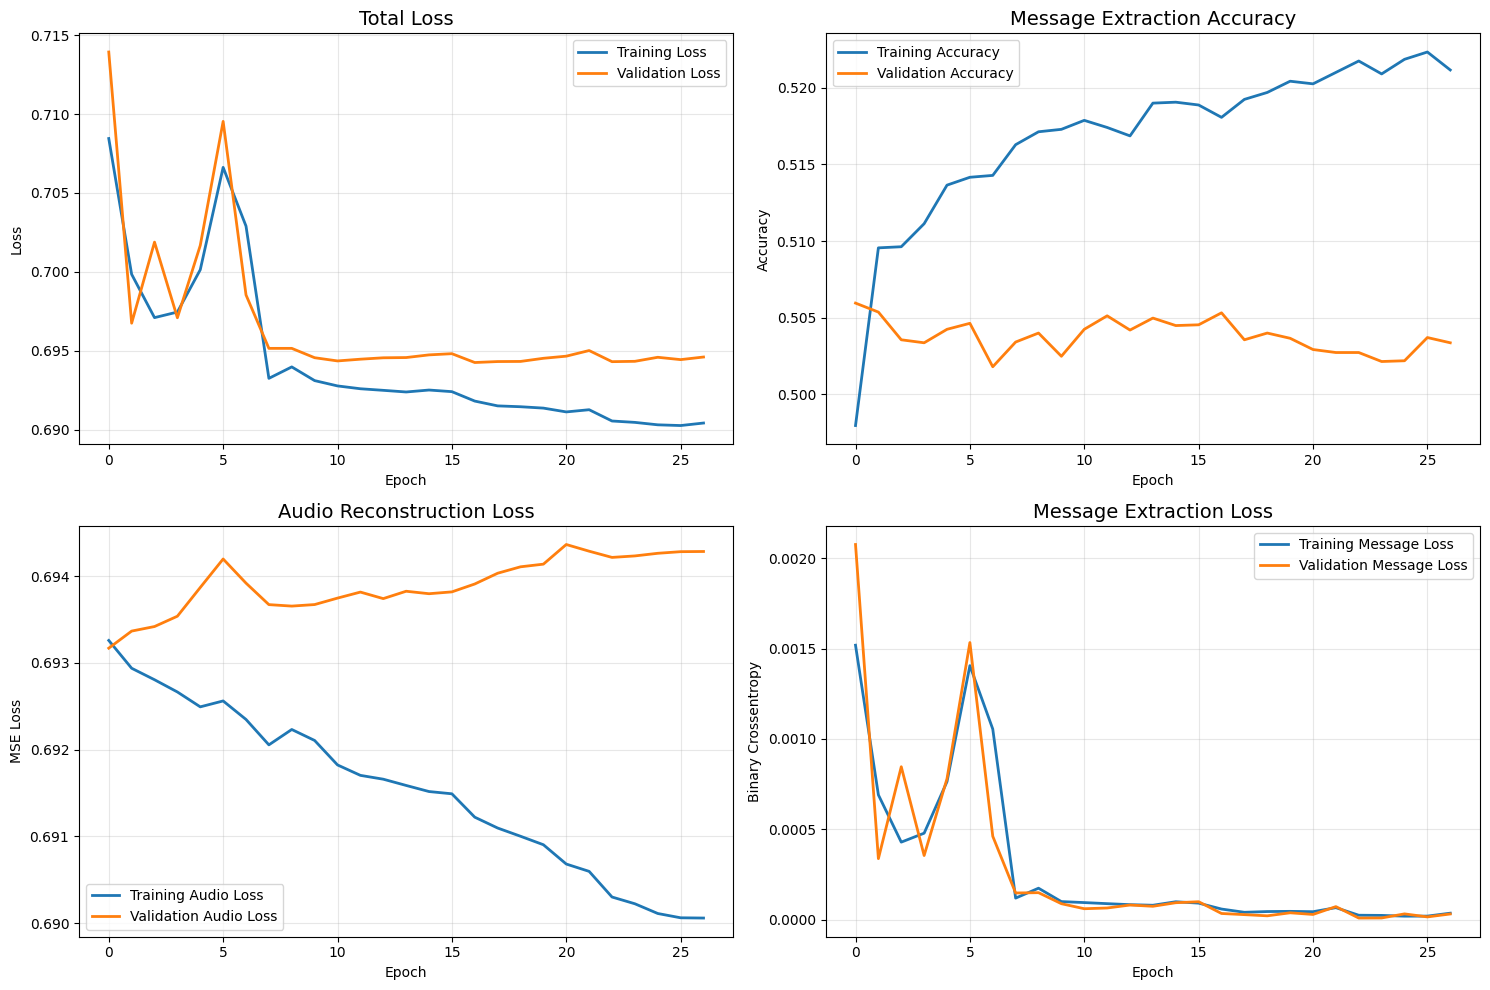

In [ ]:
print("Starting training...")
print("="*50)

# Train with your data
history = train_model(stego_model, audio_data, message_data, epochs=50, batch_size=16)

print("\n" + "="*50)
print("Training completed!")
print("="*50)

# Plot training history
plot_training_history(history)

# **Evaluate the Model**

Evaluating model performance...
Generating predictions...
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 712ms/step

EVALUATION RESULTS:
Average Signal-to-Noise Ratio (SNR): 9.51 dB
Average Peak SNR (PSNR): 28.07 dB
Overall Message Accuracy: 54.16%
Bit Error Rate (BER): 0.4584
Perfect Message Extractions: 0/40 (0.0%)


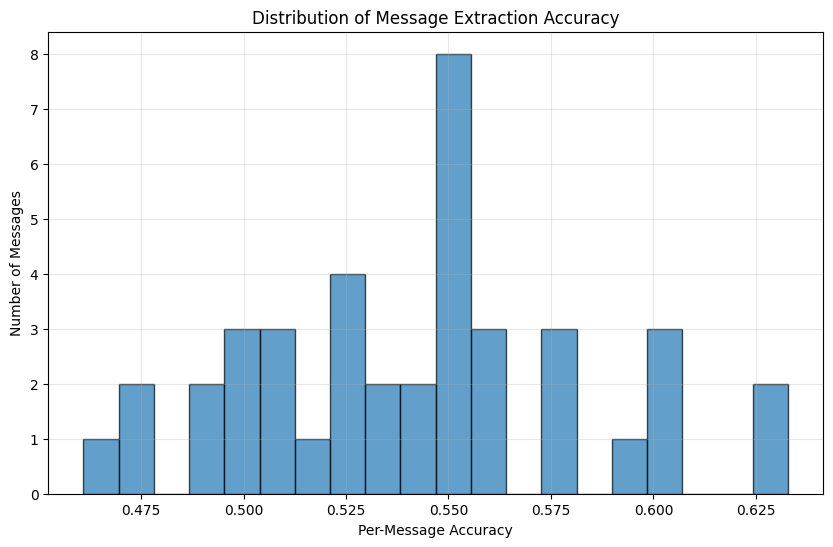

In [ ]:
# Evaluate on test data
print("Evaluating model performance...")
print("="*50)

# Use the last 20% of data for testing
test_size = int(0.2 * len(audio_data))
test_audio = audio_data[-test_size:]
test_messages = message_data[-test_size:]

# Get evaluation metrics
results = evaluate_model(stego_model, test_audio, test_messages)

print("\nEVALUATION RESULTS:")
print("="*50)
print(f"Average Signal-to-Noise Ratio (SNR): {results['avg_snr']:.2f} dB")
print(f"Average Peak SNR (PSNR): {results['avg_psnr']:.2f} dB")
print(f"Overall Message Accuracy: {results['message_accuracy'] * 100:.2f}%")
print(f"Bit Error Rate (BER): {results['ber']:.4f}")
print(f"Perfect Message Extractions: {results['perfect_messages']}/{results['total_messages']} ({results['perfect_messages']/results['total_messages']*100:.1f}%)")

# Histogram of per-message accuracy
plt.figure(figsize=(10, 6))
plt.hist(results['per_message_accuracy'], bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('Per-Message Accuracy')
plt.ylabel('Number of Messages')
plt.title('Distribution of Message Extraction Accuracy')
plt.grid(True, alpha=0.3)
plt.show()

# **Visualize Results and Test Robustness**

Visualizing steganography results...

Sample 1:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


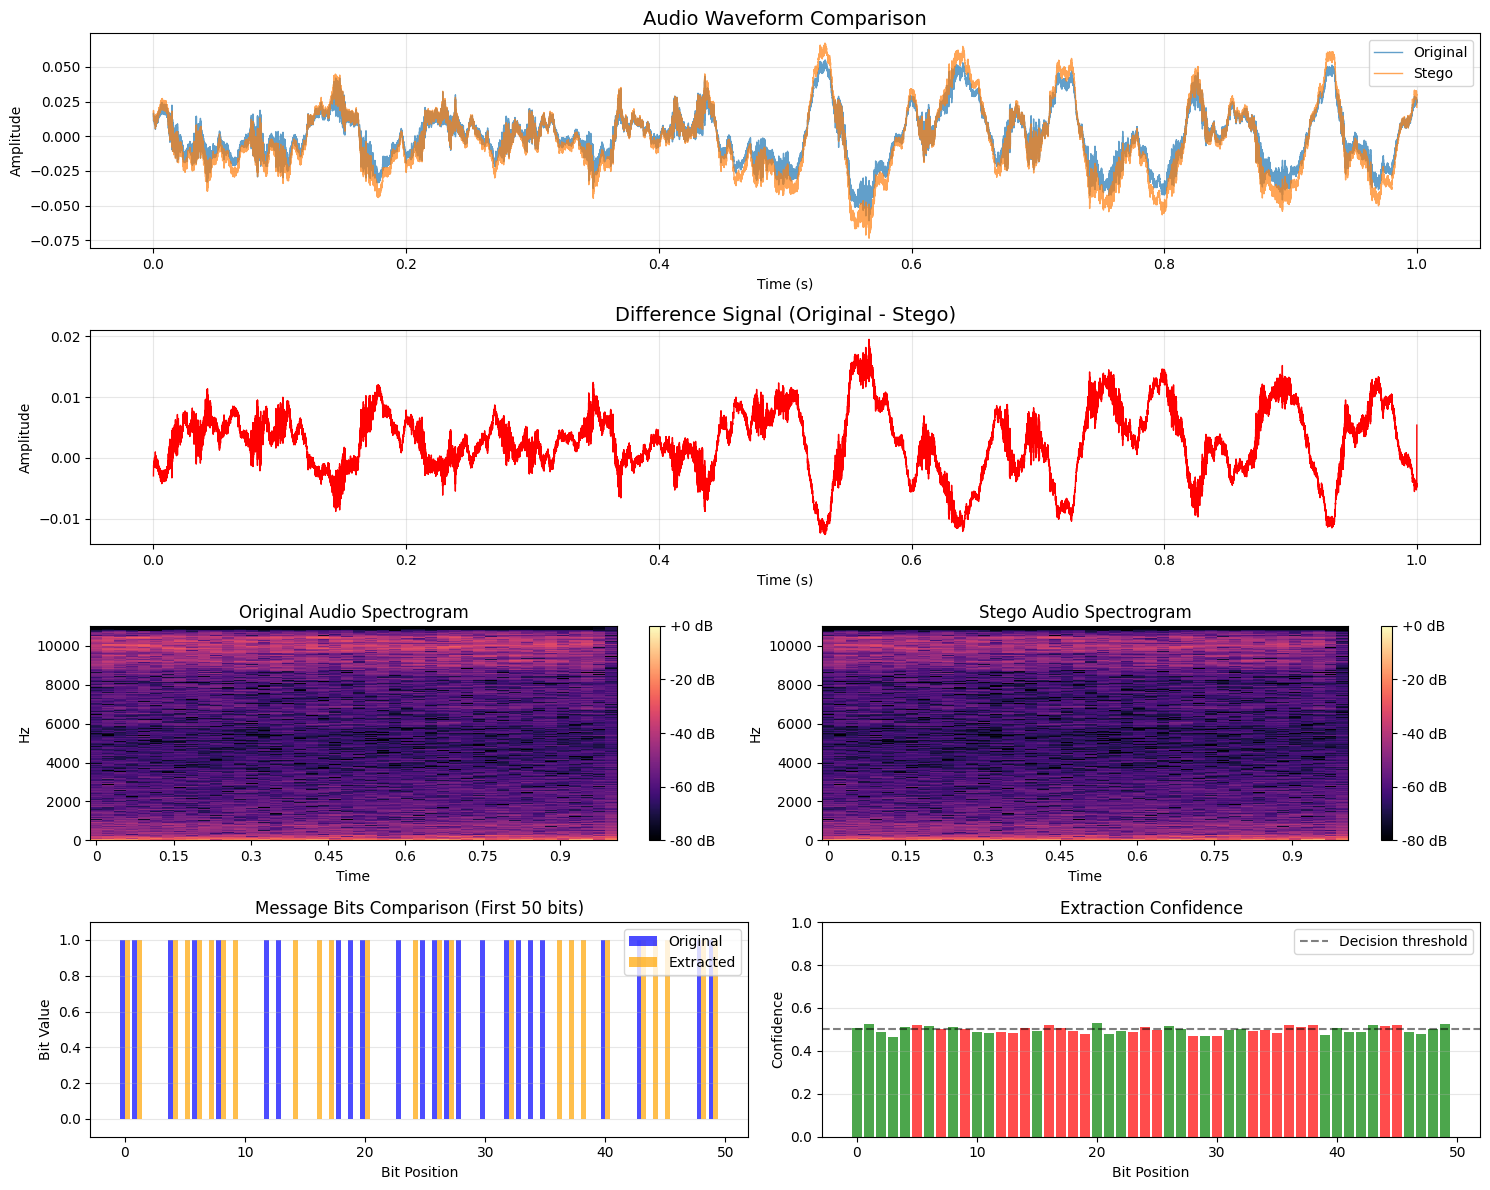


STEGANOGRAPHY METRICS:
Signal-to-Noise Ratio (SNR): 10.15 dB
Peak Signal-to-Noise Ratio (PSNR): 19.95 dB
Message Extraction Accuracy: 52.34%
Max amplitude difference: 0.019490
Mean absolute difference: 0.004951

Sample 2:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


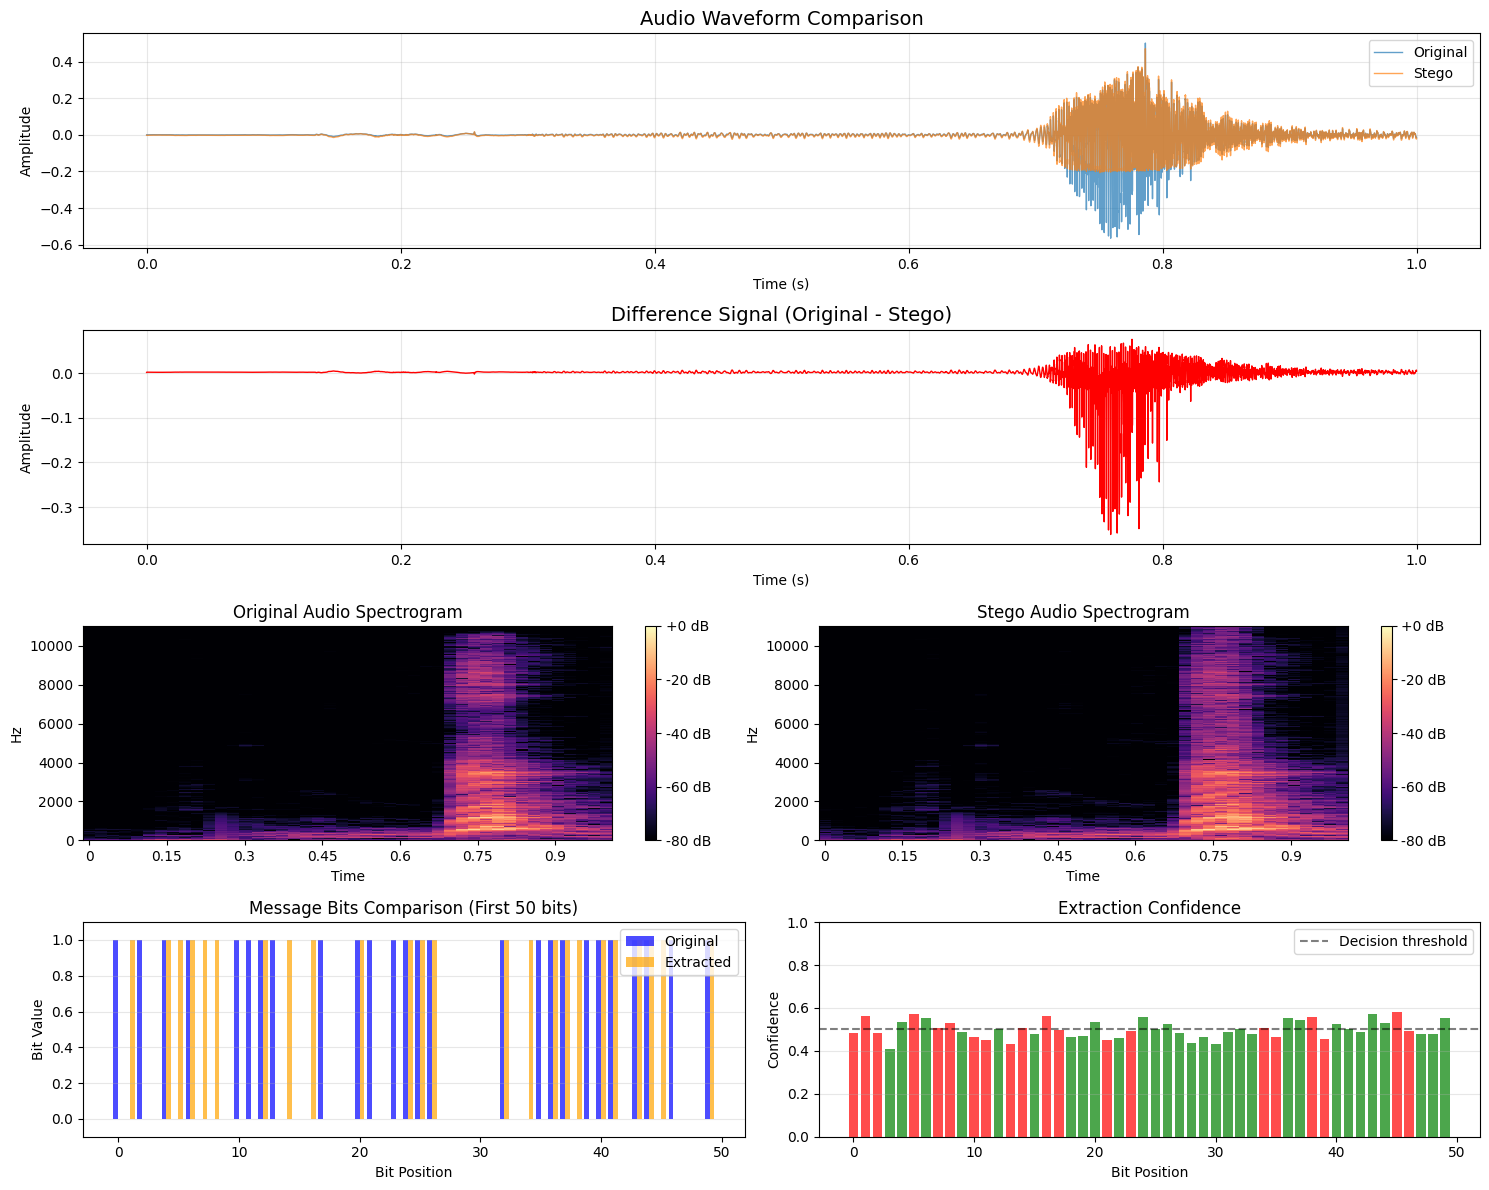


STEGANOGRAPHY METRICS:
Signal-to-Noise Ratio (SNR): 8.74 dB
Peak Signal-to-Noise Ratio (PSNR): 28.55 dB
Message Extraction Accuracy: 53.12%
Max amplitude difference: 0.361363
Mean absolute difference: 0.006449

Sample 3:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


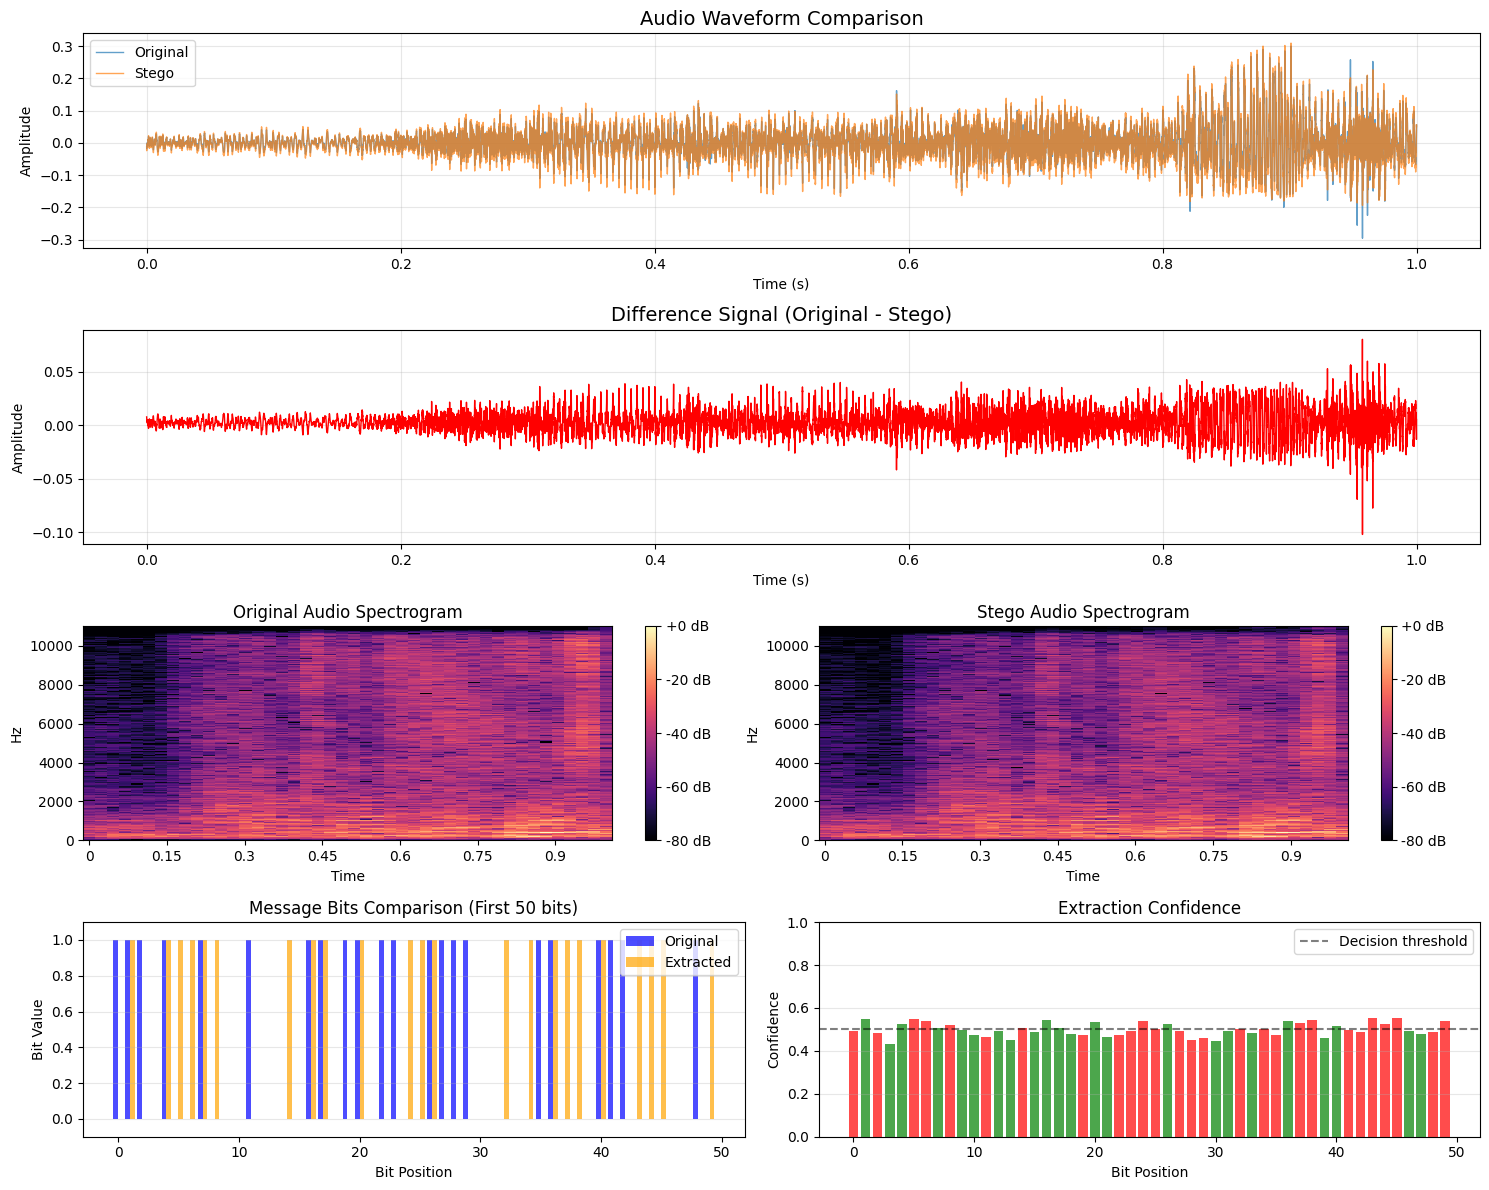


STEGANOGRAPHY METRICS:
Signal-to-Noise Ratio (SNR): 12.02 dB
Peak Signal-to-Noise Ratio (PSNR): 28.85 dB
Message Extraction Accuracy: 52.34%
Max amplitude difference: 0.101922
Mean absolute difference: 0.008023

Testing robustness against noise...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step

NOISE ROBUSTNESS RESULTS:
Noise level: 0.001 - Accuracy: 55.31%
Noise level: 0.005 - Accuracy: 55.31%
Noise level: 0.010 - Accuracy: 55.31%

AUDIO PLAYBACK COMPARISON:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Original Audio:



Stego Audio (with embedded message):



Difference (amplified 10x for audibility):


In [ ]:
# Visualize steganography results for multiple samples
print("Visualizing steganography results...")
print("="*50)

# Show results for 3 different samples
for i in range(min(3, len(test_audio))):
    print(f"\nSample {i+1}:")
    visualize_steganography_results(stego_model, test_audio, test_messages, idx=i)

# Test robustness against noise
print("\nTesting robustness against noise...")
print("="*50)

noise_results = test_robustness(stego_model, test_audio[:10], test_messages[:10])

print("\nNOISE ROBUSTNESS RESULTS:")
for result in noise_results:
    print(f"Noise level: {result['noise_level']:.3f} - Accuracy: {result['accuracy']*100:.2f}%")

# Play original and stego audio comparison
print("\n" + "="*50)
print("AUDIO PLAYBACK COMPARISON:")
print("="*50)

idx = 0  # Choose which sample to play
original = test_audio[idx].flatten()
stego_pred, _ = stego_model.combined_model.predict([test_audio[idx:idx+1], test_messages[idx:idx+1]])
stego = stego_pred[0].flatten()

print("Original Audio:")
ipd.display(ipd.Audio(original, rate=22050))

print("\nStego Audio (with embedded message):")
ipd.display(ipd.Audio(stego, rate=22050))

print("\nDifference (amplified 10x for audibility):")
ipd.display(ipd.Audio((original - stego) * 10, rate=22050))

# **Saving the Model**

In [ ]:
# Save the trained models
save_path = '/content/drive/MyDrive/graduation project/models'

# Create directory if it doesn't exist
os.makedirs(save_path, exist_ok=True)

# Save individual models
encoder_path = os.path.join(save_path, 'stego_encoder.h5')
decoder_path = os.path.join(save_path, 'stego_decoder.h5')
combined_path = os.path.join(save_path, 'stego_combined.h5')

stego_model.encoder.save(encoder_path)
stego_model.decoder.save(decoder_path)
stego_model.combined_model.save(combined_path)

print("Models saved successfully!")
print(f"Encoder saved to: {encoder_path}")
print(f"Decoder saved to: {decoder_path}")
print(f"Combined model saved to: {combined_path}")

# Save training history
import pickle

history_path = os.path.join(save_path, 'training_history.pkl')
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f)

print(f"Training history saved to: {history_path}")

Models saved successfully!
Encoder saved to: /content/drive/MyDrive/graduation project/models/stego_encoder.h5
Decoder saved to: /content/drive/MyDrive/graduation project/models/stego_decoder.h5
Combined model saved to: /content/drive/MyDrive/graduation project/models/stego_combined.h5
Training history saved to: /content/drive/MyDrive/graduation project/models/training_history.pkl
